# Modelling Time Series with Few Datapoints by Embedding Prior Knowledge using Tensorflow-Probability

This tutorial is based on [this tutorial](https://juanitorduz.github.io/short_time_series_pymc/) originally written using PyMC. All credit goes to the author of the post.

## Motivation

Imagine you are tasked with modelling bike sales in New York city but with just only a few datapoints. Let's say with only 100 samples. This is challenging as the lack of samples makes it difficult for a time series model to extract the seasonality and detect trends in the time series to predict future observations. As pointed out by [this post](https://minimizeregret.com/short-time-series-prior-knowledge), collecting more data may not necessarily be the easiest solution as seasonality can occur far in between. The common approach is to model a time series data after observing two periods of seasonality. For example, if the seasonality only occurs yearly, which means that we have to wait for two years to model our time series data. Clearly, this is not the most practical approach

But all hope is not lost. You might assume that bike sales might be positively correlated with the temperature in the city. Meaning that the hotter the temperature, the more bike is sold. So here is the idea:

1. First, we're going to model the temperature data as a [Fourier Series](https://www.educative.io/answers/how-to-implement-fourier-series-in-python) by learning the Fourier coefficients. 
2. Then, use the Fourier coefficients from the temperature model to construct the New City bike sales model.

So let's get to it.

## Imports

In [1]:
import numpy as np
import pandas as pd
import pyreadr

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [12, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

In [3]:
import tensorflow_probability as tfp
import tensorflow as tf

tfd = tfp.distributions
tfb = tfp.bijectors

In [4]:
from sklearn.preprocessing import StandardScaler

## Data Preprocessing

The bike sales and temperature data is obtained from [timradtke GitHub repository](https://github.com/timradtke/short-time-series)

The data pre-processing is fairly straightforward by combining the New City bike sales data with the New York temperature data joined with its date. The temperature is then scaled using the <code>StandardScaler</code> method from Scikit-Learn. 

In [5]:
sale_df = pyreadr.read_r('citi_bike_360.Rds')
sale_df = sale_df[None]
sale_df['date'] = pd.to_datetime(sale_df['date']).dt.date

In [6]:
temperature_df = pd.read_csv('temperature.csv', parse_dates=['datetime'])

#take only the temperature data from new york
new_york_temp = temperature_df[['datetime', 'New York']]
new_york_temp['date'] = new_york_temp['datetime'].dt.date

#take only one temperature sample from each date
new_york_temp = new_york_temp.drop_duplicates(subset=['date'])
new_york_temp = new_york_temp.dropna()

C:\Users\User\AppData\Local\Temp/ipykernel_30472/2858029491.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_york_temp['date'] = new_york_temp['datetime'].dt.date


In [7]:
new_york_temp = new_york_temp[['date', 'New York']]
sale_df = sale_df[['date', 'rides']]

In [8]:
#join the sales and temperature data based on the date
raw_df = pd.merge(sale_df, new_york_temp, how='left', on='date')

In [9]:
start_date = pd.to_datetime("2013-07-01")
train_test_date = pd.to_datetime("'2013-10-15'")

In [10]:
raw_df['date'] = pd.to_datetime(raw_df['date'])
raw_df[['date', 'sales', 'temp']] = raw_df
raw_df = raw_df[['date', 'sales', 'temp']]

#scale the temperature data
raw_df['temp_scaled'] = raw_df['temp'] - raw_df['temp'].min()
raw_df['trend'] = (raw_df.sales.index - sum(raw_df['date'] <= train_test_date)) / 365.25

In [11]:
raw_df =  raw_df.dropna()

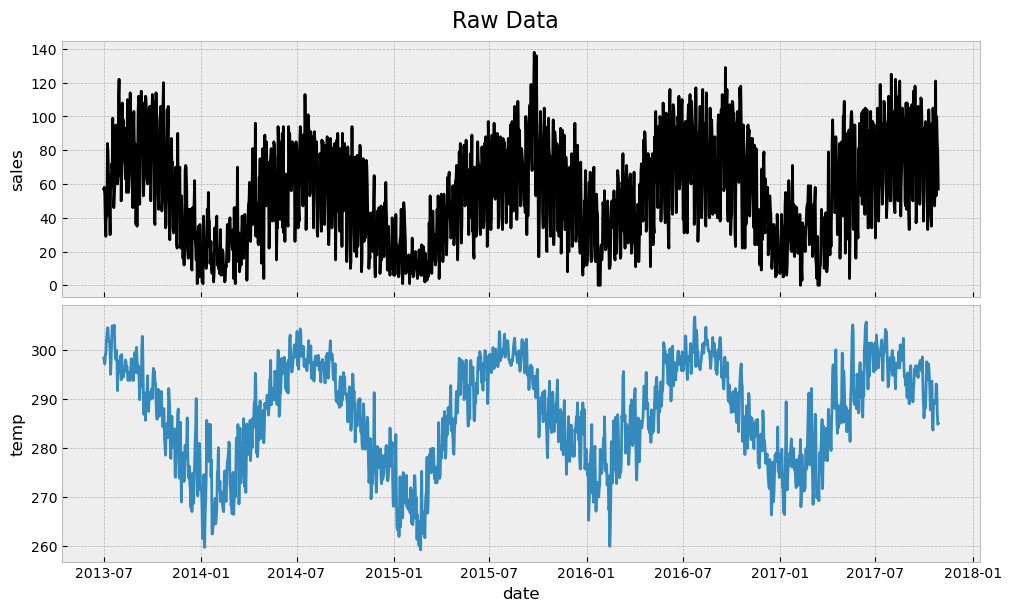

In [12]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(10, 6), sharex=True, sharey=False, layout="constrained"
)
sns.lineplot(x="date", y="sales", data=raw_df, color="black", ax=ax[0])
sns.lineplot(x="date", y="temp", data=raw_df, color="C0", ax=ax[1])
fig.suptitle("Raw Data", fontsize=16);

# The Temperature Model

The model described below is what satisticians call a Poisson regression model, which is a type of a class of statistical modelling technique called Generalized Linear Model (GLM). In the classical Linear Regression model, the observation assumes a Normal distribution with noise $\sigma^2$. A GLM generalizes this by also allowing the observation to take other distributions, which in this case is the Poisson distribution. The log function below is the link function that "links" the linear model which is a Fourier Series to the parameter of the Poisson distribution.

$ temp_t \sim Poisson(\mu_t) $
<br>
$ log(\mu_t) = a + \displaystyle\sum_{k=1}^{K=6}b_k \sin(\frac{2\pi kt}{m}) + \tilde b_k \cos(\frac{2\pi kt}{m}), m = 365.25$
<br>
$a \sim Normal(0, 1)$
<br>
$ b_k, \tilde b_k \sim Normal(0,1) $

The goal of this model is to learn the parameters of the linear model, which are the intercept $ a $ and the Fourier coefficients $b_k$ and $\tilde b_k$.

First, we extract all the features that are required for the temperature model.

In [13]:
date = raw_df["date"]
temp_scaled = raw_df["temp_scaled"]
trend = raw_df["trend"]
sales = raw_df["sales"]
# We extract the day of week for the sales model below.
dayofweek_idx, dayofweek = raw_df["date"].dt.dayofweek.factorize()

In [14]:
periods = raw_df["date"].dt.dayofyear / 365.25
n_order = 6

We construct the Fourier features as in [this post](https://www.pymc.io/projects/examples/en/latest/time_series/Air_passengers-Prophet_with_Bayesian_workflow.html).

In [15]:
fourier_features = pd.DataFrame(
    {
        f"{func}_order_{order}": getattr(np, func)(2 * np.pi * periods * order)
        for order in range(1, n_order + 1)
        for func in ("sin", "cos")
    }
)

fourier_features.head()

,sin_order_1,cos_order_1,sin_order_2,cos_order_2,sin_order_3,cos_order_3,sin_order_4,cos_order_4,sin_order_5,cos_order_5,sin_order_6,cos_order_6
0,0.010751,-0.999942,-0.021501,0.999769,0.032249,-0.999480,-0.042993,0.999075,0.053732,-0.998555,-0.064464,0.997920
1,-0.006451,-0.999979,0.012901,0.999917,-0.019352,-0.999813,0.025801,0.999667,-0.032249,-0.999480,0.038696,0.999251
2,-0.023651,-0.999720,0.047289,0.998881,-0.070900,-0.997483,0.094472,0.995527,-0.117991,-0.993015,0.141444,0.989946
3,-0.040844,-0.999166,0.081621,0.996663,-0.122261,-0.992498,0.162697,0.986676,-0.202861,-0.979208,0.242687,0.970105
4,-0.058026,-0.998315,0.115856,0.993266,-0.173295,-0.984870,0.230151,0.973155,-0.286231,-0.958161,0.341347,0.939938


In [16]:
fourier_features = fourier_features.values
fourier_features = np.array(fourier_features, dtype=np.float32)

In [17]:
temp_scaled = temp_scaled.values

Constructing the model in TFP is fairly straightforward. First, we specify the priors $a$ and $b$. Then, the linear model described in the equation above is described. And finally, the likelihood function is parameterized using the linear model.

The model is constructed as a joint probability distribution using the <code>tfd.JointDistributionCoroutineAutoBatched</code> method that returns a <code>tfd.Distribution</code> instance, which allows us to sample and compute the log likelihood of the distribution easier. This will come in handy when we want to sample from the prior predictive and fit the model using MCMC.

In [18]:
def make_temperature_model():
    def model():
        #priors
        a = yield tfd.Normal(loc=0, scale=1, name='a')
        b  = yield  tfd.Normal(loc=tf.zeros(shape=(1,12)), scale=1,name='b')
        
        #the linear model
        mu_t = a + tf.linalg.matmul(b, fourier_features.T)
        
        #the 
        likelihood = yield tfd.Poisson(rate=tf.math.exp(mu_t[0]), name='likelihood')
    return tfd.JointDistributionCoroutineAutoBatched(model)

Below we write the helper function that returns the log likelihood function given the observation $P(\theta|X)P(X)$. This is really easy to do - although it is not necessary if we are using PyMC - by pinning the log probability function to the observed temperature.  

In [19]:
temperature_model = make_temperature_model()

In [20]:
def temp_log_prob(a, b):
    return temperature_model.log_prob([a, b, temp_scaled])

In [21]:
t = temperature_model.sample()

In [22]:
temp_log_prob(t[0], t[1])

<tf.Tensor: shape=(), dtype=float32, numpy=-144631.75>

Next, we need to run a sanity check by sampling from the prior predictive distribution to ensure that our specified model does not produce values that does not make sense and that the prior distribution is not too restrictive.

In [23]:
temp_prior_predictive = temperature_model.sample(1000)

In [24]:
temp_pred = temp_prior_predictive[-1]
#remove dimensions of size 1
temp_pred = tf.squeeze(temp_pred).numpy()

C:\Users\User\Anaconda3\envs\bayesian\lib\site-packages\arviz\stats\stats.py:493: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
C:\Users\User\Anaconda3\envs\bayesian\lib\site-packages\arviz\stats\stats.py:493: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


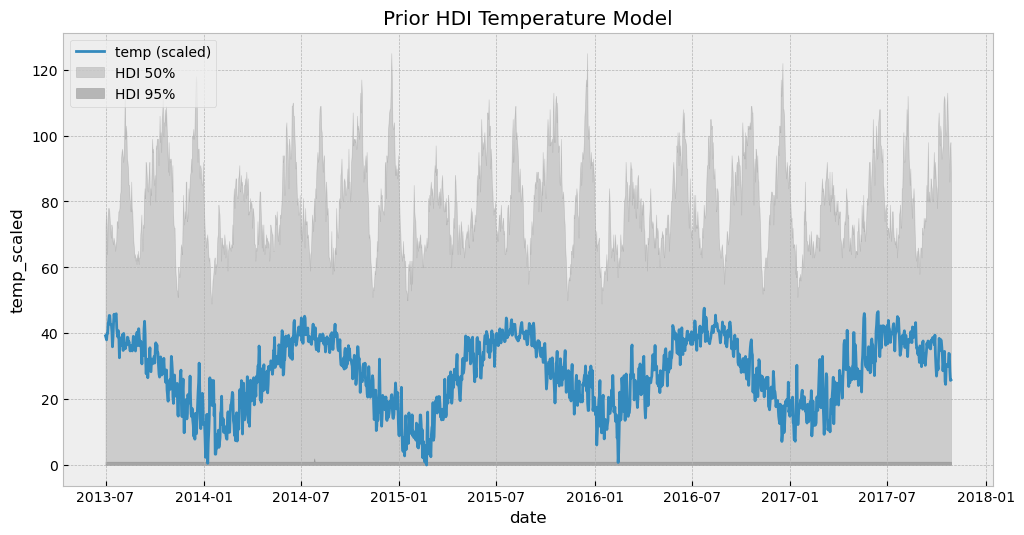

In [25]:
fig, ax = plt.subplots()

sns.lineplot(
    x="date", y="temp_scaled", data=raw_df, color="C0", label="temp (scaled)", ax=ax
)
az.plot_hdi(
    x=date,
    y=temp_pred,
    hdi_prob=0.95,
    color="gray",
    smooth=False,
    fill_kwargs={"label": "HDI 50%", "alpha": 0.3},
    ax=ax,
)
az.plot_hdi(
    x=date,
    y=temp_pred,
    hdi_prob=0.5,
    color="gray",
    smooth=False,
    fill_kwargs={"label": "HDI 95%", "alpha": 0.5},
    ax=ax,
)
ax.legend(loc="upper left")
ax.set(title="Prior HDI Temperature Model");

Now, its time to fit the model by sampling from the posterior. But before we do that, we need to find a good parameter initialization for the sampling algorithm so it have a good starting point to begin with. A good initialization point would be the MAP estimate of the posterior $\arg \max_{\theta} \log P(\theta|X)P(\theta)$. Usually, we don't have to do this by initializing the initialization to either a zero or one initialization. But I found that, without the MAP initialization, the MCMC sampler returns no samples possibly because it took too long for the MCMC sampler to converge. 

We first initialize the parameter values to the sampled values earlier. To find the MAP values of the parameters is straightforward by minimizing the Negative Log Likelihood (NLL) with respect to the parameters via gradient descent. As the dataset is small, no minibatching is required. So the parameter estimates converges smoothly.

In [26]:
a = tf.Variable(initial_value=t[0], trainable=True)
b = tf.Variable(initial_value=t[1], trainable=True)

In [27]:
optimizer = tf.optimizers.Adam(learning_rate=0.001)
losses = []
for _ in range(5000): 
    with tf.GradientTape() as tape:
        #minimize the Negative Log Likelihood
        loss = -temp_log_prob(a, b)
    grad = tape.gradient(loss, [a, b])
    optimizer.apply_gradients(zip(grad, [a, b]))
    losses.append(loss)

Text(0.5, 1.0, 'Loss vs Iteration')

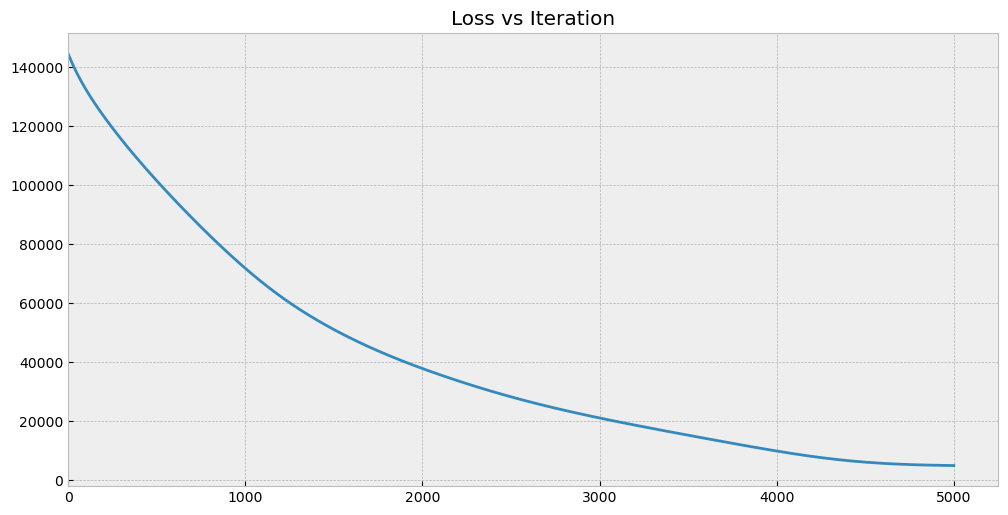

In [28]:
plt.plot(losses)
plt.xlim(0)
plt.title('Loss vs Iteration')

In [29]:
print('MAP estimate of "a":', a.numpy())

MAP estimate of "a": 3.1585076


In [30]:
print('MAP estimate of "b":', tf.squeeze(b).numpy())

MAP estimate of "b": [-0.24258938 -0.5375055  -0.09804779 -0.06098242 -0.04419089  0.01771933
 -0.01006391  0.03532837  0.00095302  0.01676524  0.00282993  0.01910761]


In [31]:
b = tf.reshape(b, shape=(1, 1, 12))

Now we're ready to run the MCMC sampling of the posterior for inference. In PyMC, this can be achieved with only two lines. We don't have such luxury when using TFP as we need to specify which sampling algorithm to use e.g., a Hamiltonian Monte Carlo or a No U-Turn Sampler and also the uncostraining bijectors to map the values to an uncostrained space. The sampling algorithm is also initialized using the MAP estimate obtained previously.

In [32]:
@tf.function
def sample_posterior(num_chains, num_results, num_burnin_steps):
    
    def trace_fn(_, pkr):
        return (
            pkr.inner_results.target_log_prob,
            pkr.inner_results.leapfrogs_taken,
            pkr.inner_results.has_divergence,
            pkr.inner_results.energy,
            pkr.inner_results.log_accept_ratio
        )
    
    hmc = tfp.mcmc.NoUTurnSampler(
        target_log_prob_fn=temp_log_prob,
        step_size=0.001
    )
    
    #initialize using the MAP estimate
    initial_state = [
        tf.repeat(a, num_chains, axis=0, name='init_a'),
        tf.tile(tf.reshape(b, shape=(1, 1, 12)), multiples=[num_chains,1, 1], name='init_b')
    ]
    
    unconstraining_bijectors = [
        tfb.Softplus(),
        tfb.Identity()
    ]
    
    kernel = tfp.mcmc.TransformedTransitionKernel(
        inner_kernel=hmc, bijector=unconstraining_bijectors
    )
    
    samples, kernel_results = tfp.mcmc.sample_chain(
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        current_state=initial_state,
        kernel=kernel,
        trace_fn=trace_fn
    )
    
    

   
    return samples, kernel_results

In [33]:
samples, sampler_stat = sample_posterior(
    num_chains=4, num_results=4000, num_burnin_steps=1000)

C:\Users\User\Anaconda3\envs\bayesian\lib\site-packages\tensorflow_probability\python\__init__.py:70: UserWarning: TensorFloat-32 matmul/conv are enabled for NVIDIA Ampere+ GPUs. The resulting loss of precision may hinder MCMC convergence. To turn off, run `tf.config.experimental.enable_tensor_float_32_execution(False)`. For more detail, see https://github.com/tensorflow/community/pull/287.
  warnings.warn(


Once the sampling is completed, the results is stored using the PyMC3 convention into a dictionary array

In [34]:
sample_stats_name = ['lp', 'tree_size', 'diverging', 'energy', 'mean_tree_accept']

In [35]:
sample_stats = {k:v.numpy().T for k, v in zip(sample_stats_name, sampler_stat)}

In [36]:
sample_stats['tree_size'] = np.diff(sample_stats['tree_size'], axis=1)


In [37]:
var_name = ['a', 'b_fourier']
posterior = {k:np.swapaxes(tf.squeeze(v).numpy(), 1, 0) 
             for k, v in zip(var_name, samples)}

Fantastic!!! The results from the sampling shows that the parameters converges to a certain distribution. Here, it shows that all parameters resembles a Normal distrbution centered around the mean which also happens to be around the MAP estimate. 

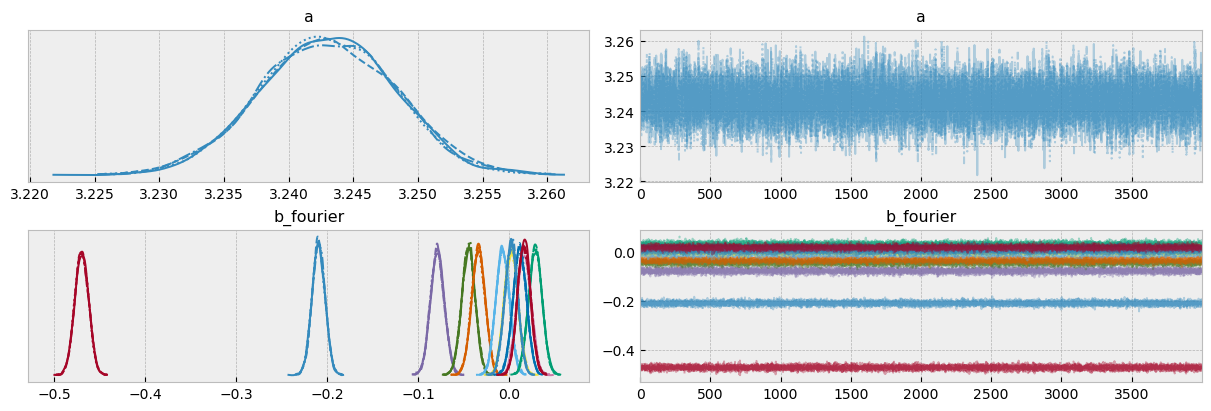

In [38]:
az_trace = az.from_dict(posterior=posterior)
az.plot_trace(az_trace);

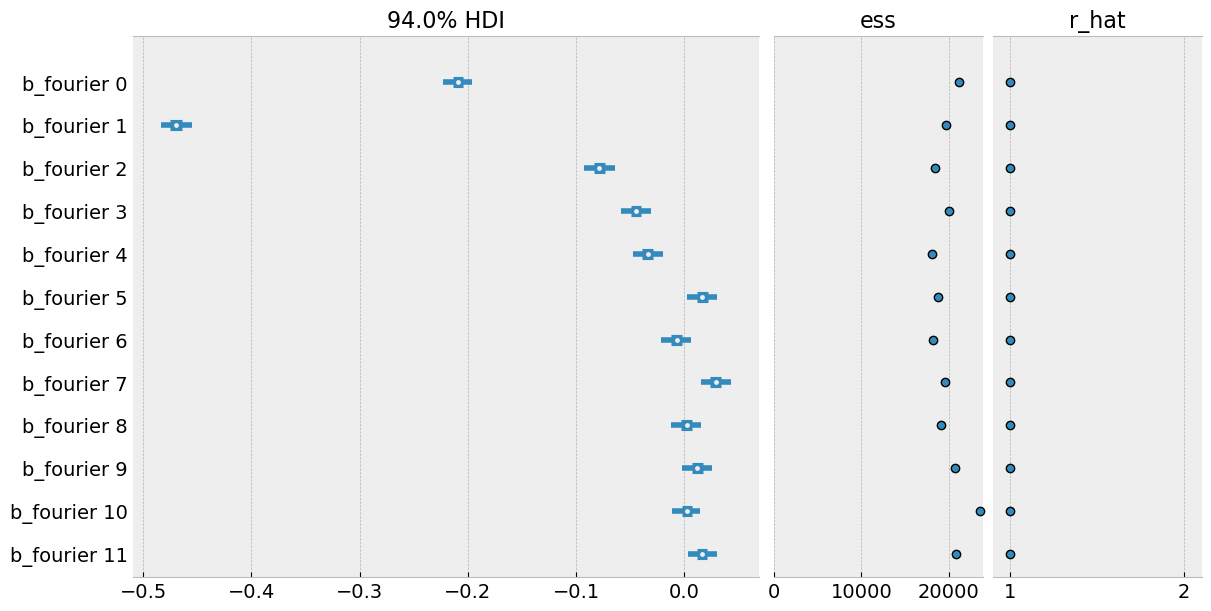

In [39]:
az.plot_forest(az_trace,
               kind="forestplot",
               var_names=['b_fourier'],
               linewidth=4,
               r_hat=True,
               ess=True,
               combined=True,
               ridgeplot_overlap=1.5,
               figsize=(12, 6));

Now it's time to plot the posterior predictive distribution: <br>

$P(X|\theta) = \int P(X|\theta)P(\theta|X) d\theta$ 

And, of course we're going to approximate the integral using the parameter samples obtained earlier.

In [40]:
a_samples = samples[0][:,0]

In [41]:
b_samples = samples[1][:, 0, :, :]

First we reshape the Fourier features so we can multiply it with all the parameter samples

In [42]:
ff = tf.tile(tf.reshape(fourier_features.T, shape=[1, 12, -1]), [4000, 1, 1])

Now, compute the linear model for the Poisson regression model.

In [43]:
mu_t = tf.reshape(a_samples, shape=(4000, 1)) + tf.squeeze(tf.linalg.matmul(b_samples, ff))

And pass the $\mu_t$ value to the Poisson distribution. Here we make each parameter distribution samples to be independent to each other by using the <code>tfd.Independent</code> method. Refer to [this](https://www.tensorflow.org/probability/examples/TensorFlow_Distributions_Tutorial) tutorial for more details.

In [44]:
temp_dist = tfd.Independent(tfd.Poisson(rate=tf.math.exp(mu_t)), reinterpreted_batch_ndims=1)

In [45]:
temp_pred = temp_dist.sample().numpy()

C:\Users\User\Anaconda3\envs\bayesian\lib\site-packages\arviz\stats\stats.py:493: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
C:\Users\User\Anaconda3\envs\bayesian\lib\site-packages\arviz\stats\stats.py:493: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


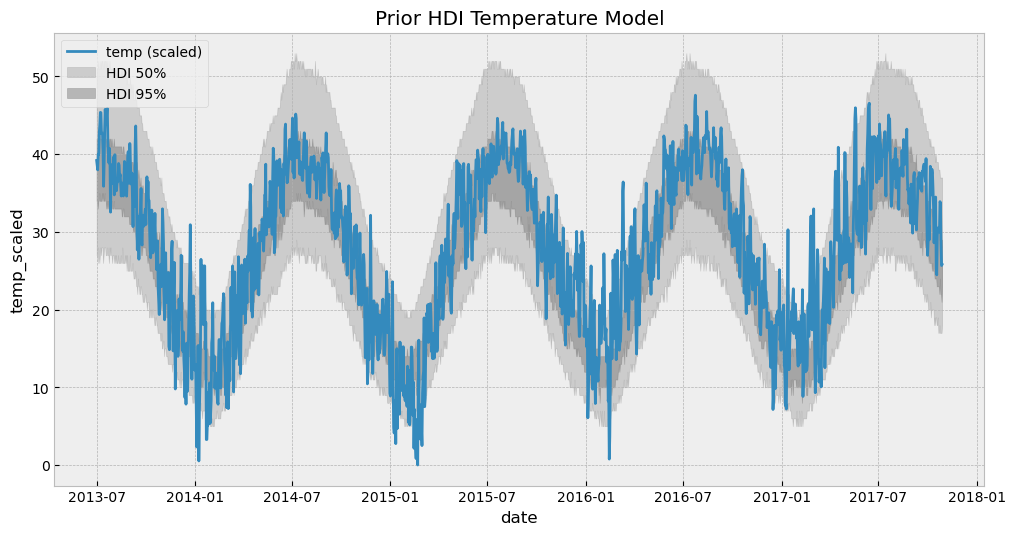

In [46]:
fig, ax = plt.subplots()

sns.lineplot(
    x="date", y="temp_scaled", data=raw_df, color="C0", label="temp (scaled)", ax=ax
)
az.plot_hdi(
    x=date,
    y=temp_pred,
    hdi_prob=0.95,
    color="gray",
    smooth=False,
    fill_kwargs={"label": "HDI 50%", "alpha": 0.3},
    ax=ax,
)
az.plot_hdi(
    x=date,
    y=temp_pred,
    hdi_prob=0.5,
    color="gray",
    smooth=False,
    fill_kwargs={"label": "HDI 95%", "alpha": 0.5},
    ax=ax,
)
ax.legend(loc="upper left")
ax.set(title="Prior HDI Temperature Model");

Looks good. The temperature model manages to recover the temperature trend by using the Fourier features as the regression features.

## Sales Model

Now we have arrived to the main objective of this tutorial, which is to incorporate prior knowledge to model short time series data. 

The sales model described below is a NegativeBinomial regression model parameterized by the mean $\mu_t$ that is a damped mean dynamic that combines information from previous observation $sales_{t-1}$ and seasonality coefficient $\lambda_t$ at each time step. In addition to the Fourier seasonality, the seasonality coefficient $\lambda_t$ also takes into accound the day of week effect and the trend effect $b_{trend}$.

The prior knowledge regarding the seasonality of the sales is embedded in the prior distribution of the Fourier coefficient $b^{'}_k$ and $\tilde b^{'}_K$ that has the same distribution as the posterior of the temperature model obtained previously.

$sales_t \sim NegativeBinomial(\mu_t, \alpha)$ <br>

$\mu_t = (1-\delta-\eta)\lambda_t + \delta\mu_{t-1} + \eta sales_{t-1}, 0\leq\delta\leq1, 0 \leq \eta \leq 1 - \delta$ <br>

$\log(\lambda_t) = b_{trend}\frac{t}{m} + \displaystyle\sum^{7}_{j=1}b_{dow,j}dayofweek_t + \displaystyle\sum_{k=1}^{K=6}b^{'}_k\sin (\frac{2\pi kt}{m}) + \tilde b_k^{'}\cos(\frac{2\pi kt}{m}), m=365.25$ <br>

$\delta \sim Beta(1,10)$<br>
$\eta \sim Gamma(1,10)$<br>
$b_{trend} \sim Normal(0.03, 0.02)$ <br>
$b_{dow,j} \sim Normal(4,2)$<br>
$b^{'}_{k} \sim Normal(\mathbb{E}[b_k], \sqrt{Var[b^{'}_k]})$ <br>
$\tilde b^{'}_{k} \sim Normal(\mathbb{E}[\tilde b^{'}_{k}],\sqrt{Var[\tilde b^{'}_{k}]})$ <br>
$\alpha \sim Normal(0.5)$

First, we separate the time series into training and test sets. 

In [47]:
start_date = pd.to_datetime("2013-07-01")
train_test_date = pd.to_datetime("'2013-10-15'")

In [48]:
df_train = raw_df[raw_df['date'] <= train_test_date]
df_test = raw_df[raw_df['date'] > train_test_date]

In [49]:
n_train = df_train.shape[0]
n_test = df_test.shape[0]
n = n_test + n_train

<AxesSubplot:xlabel='date', ylabel='sales'>

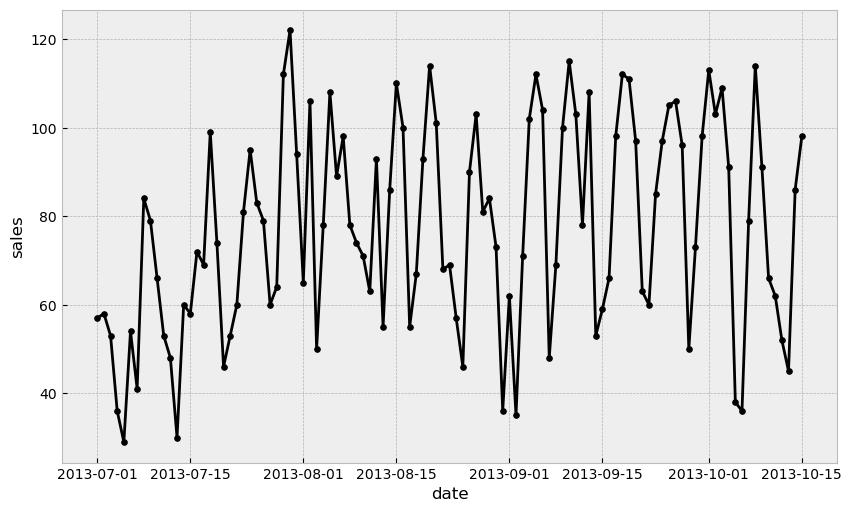

In [50]:
plt.figure(figsize=(10, 6))
sns.lineplot(
    x="date",
    y="sales",
    data=df_train,
    color="black",
    marker="o",
    markersize=4,
    markeredgecolor="black",
)

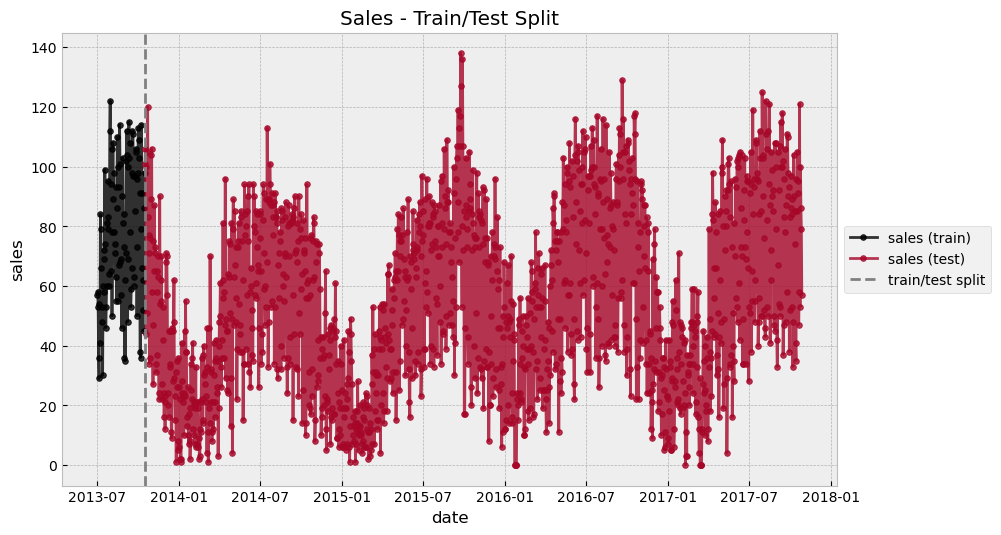

In [51]:
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(
    x="date",
    y="sales",
    data=df_train,
    marker="o",
    color="black",
    alpha=0.8,
    markersize=4,
    markeredgecolor="black",
    label="sales (train)",
    ax=ax,
)
sns.lineplot(
    x="date",
    y="sales",
    data=df_test,
    marker="o",
    color="C1",
    alpha=0.8,
    markersize=4,
    markeredgecolor="C1",
    label="sales (test)",
    ax=ax,
)
ax.axvline(x=train_test_date, color="gray", linestyle="--", label="train/test split")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Sales - Train/Test Split");

Next, we extract the features that we are interested in, and construct the Fourier features as before.

In [52]:
date_train = df_train["date"].values
sales_train = df_train["sales"].values
trend_train = df_train["trend"].values
dayofweek_idx_train, dayofweek_train = df_train["date"].dt.dayofweek.factorize()

periods_train = df_train["date"].dt.dayofyear / 365.25
n_order = 6

fourier_features_train = pd.DataFrame(
    {
        f"{func}_order_{order}": getattr(np, func)(2 * np.pi * periods_train * order)
        for order in range(1, n_order + 1)
        for func in ("sin", "cos")
    }
)

fourier_features_train = fourier_features_train.values

fourier_features_train = np.array(fourier_features_train, dtype=np.float32)

Here, we calculate the mean and the standard deviation of the posterior of the Fourier coefficient from the temperature model to parameterize the prior of the Fourier coefficient in the sales model.

In [53]:
fourier_loc = np.mean(samples[1][:, 0, :, :], axis=0)
fourier_sd = np.std(samples[1][:, 0, :, :], axis=0)

Now, we construct the sales model as described previously. Note that we use the <code>tfd.NegativeBinomial.experimental_from_mean_dispersion</code> to construct the NegativeBinomial model as the default parameterization by TFP requires to input the number of failures and the probability of success. So thankfully this method exists to make the parameterization of the NegativeBinomial model easier.

In [54]:
def make_sales_forecast_model():
    
    def model():
        
        delta = yield tfd.Beta(concentration1=1, concentration0=10, name='delta')
        eta = yield tfd.Gamma(concentration=0.5, rate=10, name='eta')
        b_trend  = yield tfd.Normal(loc=0.03, scale=0.02, name='b_trend')
        b_dayofweek = yield tfd.Normal(loc=tf.repeat(4., len(dayofweek)), scale=2, name='day_of_week')
        b_fourier = yield tfd.Normal(loc=fourier_loc, scale=fourier_sd, name='b_fourier')
        alpha = yield tfd.Normal(loc=0, scale=0.5, name='alpha')
        
        
        fourier_contribution = tf.linalg.matmul(b_fourier, fourier_features_train.T)[0]
        
        dayofweek_contibution = tf.gather(b_dayofweek, dayofweek_idx_train)
        
        trend_contribution = b_trend * trend_train
        
        seasonality = tf.math.exp(fourier_contribution + dayofweek_contibution + trend_contribution)
        alpha = tf.math.square(alpha)
        mu = tf.ones([len(sales_train)], dtype=np.float32)
        
        mu = tf.unstack(mu)
        mu[0] = sales_train[0]
        
        for i in range(1, len(mu)):
            mu[i] = (1 - delta - eta) * seasonality[i] + delta * mu[i-1] + eta * sales_train[i-1]
        mu = tf.stack(mu)
        sales = yield tfd.NegativeBinomial.experimental_from_mean_dispersion(mean=mu, dispersion=alpha, name='likelihood')
        
#         print(seasonality)
    return tfd.JointDistributionCoroutineAutoBatched(model) 
        

As before, we will view the prior predictive distribution as a sanity check to verify that our constructed model is correct.

In [55]:
sales_model = make_sales_forecast_model()

In [56]:
sales_sample = sales_model.sample(1000)

In [57]:
sales_sample = sales_sample[-1].numpy()

C:\Users\User\Anaconda3\envs\bayesian\lib\site-packages\arviz\stats\stats.py:493: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
C:\Users\User\Anaconda3\envs\bayesian\lib\site-packages\arviz\stats\stats.py:493: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


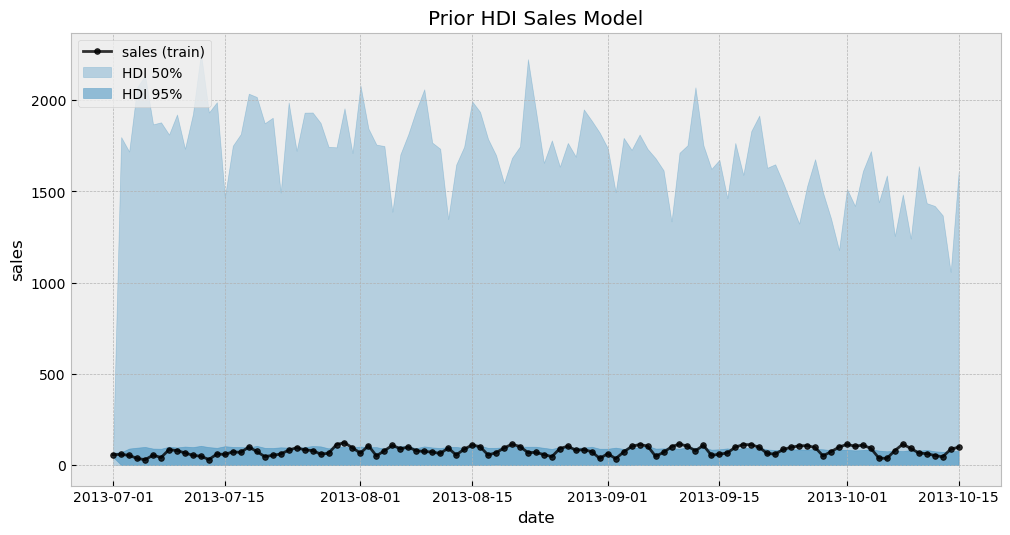

In [58]:
fig, ax = plt.subplots()

sns.lineplot(
    x="date",
    y="sales",
    data=df_train,
    marker="o",
    color="black",
    alpha=0.8,
    markersize=4,
    markeredgecolor="black",
    label="sales (train)",
)
az.plot_hdi(
    x=date_train,
    y=sales_sample,
    hdi_prob=0.95,
    color="C0",
    smooth=False,
    fill_kwargs={"label": "HDI 50%", "alpha": 0.3},
    ax=ax,
)
az.plot_hdi(
    x=date_train,
    y=sales_sample,
    hdi_prob=0.5,
    color="C0",
    smooth=False,
    fill_kwargs={"label": "HDI 95%", "alpha": 0.5},
    ax=ax,
)
ax.legend(loc="upper left")
ax.set(title="Prior HDI Sales Model");

Below we have specified two helper functions to calculate the log probability of the joint distribution, one for the MAP estimete and the other for the MCMC sampling. The reason for two separate log probability, is to enforce the constraint for the $\delta$ and $\eta$ variables. The original [tutorial](https://juanitorduz.github.io/short_time_series_pymc/) that uses PyMC3 adds negative infinity ($-\infty$) to the log probability if the constraint is violated, forcing the MCMC algorithm to explore the region where the constraint is satisfied. Or in constraint optimization speak, the feasible space. However, this approach induces stability issues when being applied to gradient descent algorithm for the MAP estimate. Therefore, for the purpose of the MAP estimate, a bijector is applied to map the variable to the feasible space and for the mcmc, the constraint is enforced by adding negative infinity ($-\infty$) to the log probability.

In [59]:
@tf.function
def sales_log_prob(delta, eta, b_trend, day_of_week, b_fourier, alpha):
    
#     sales_lp = sales_model.log_prob([delta, eta, b_trend, day_of_week, b_fourier, alpha, sales_train])
    
#     #check if satisfy 0 <= eta <= (1 - delta)
#     constrain = tf.logical_and(tf.greater_equal(eta, 0), tf.less_equal(eta, (1-delta))) 
    
#     # add infinity to the log probability if constraint is not satisfied
#     log_prob = tf.cond(constrain, true_fn=lambda: sales_lp, false_fn=lambda: sales_lp - 1000000000) 

# #     return log_prob
    delta = tfb.SoftClip(low=0, high=1).forward(delta)
    eta = tfb.SoftClip(low=0, high=(1-delta)).forward(eta)
    

    return sales_model.log_prob([delta, eta, b_trend, day_of_week, b_fourier, alpha, sales_train])

In [60]:
@tf.function
def sales_log_prob_mcmc(delta, eta, b_trend, day_of_week, b_fourier, alpha):
    
    sales_lp = sales_model.log_prob([delta, eta, b_trend, day_of_week, b_fourier, alpha, sales_train])

#     #check if satisfy 0 <= eta <= (1 - delta)
    constrain = tf.logical_and(tf.greater_equal(eta, 0), tf.less_equal(eta, (1-delta))) 
    
#     # add infinity to the log probability if constraint is not satisfied
    log_prob = tf.where(constrain, x=sales_lp, y=-np.inf) 
    

    return log_prob


In [61]:
s = sales_model.sample()

In [62]:
delta = tf.Variable(s[0], trainable=True, name='delta')
eta = tf.Variable(s[1], trainable=True, name='eta')
b_trend = tf.Variable(s[2], trainable=True, name='b_trend')
day_of_week = tf.Variable(s[3], trainable=True, name='day_of_week')
b_fourier = tf.Variable(s[4], trainable=True, name='b_fourier')
alpha = tf.Variable(s[5], trainable=True, name='alpha')

In [63]:
trainable_variables =[
    delta,
    eta,
    b_trend,
    day_of_week,
    b_fourier,
    alpha
]

As before, we minimize the Negative Log Likelihood (NLL) with respect to all the parameters.

In [64]:
optimizer = tf.optimizers.Adam(learning_rate=0.001)
losses = []
for _ in range(7000): 
    with tf.GradientTape() as tape:
        loss = -sales_log_prob(trainable_variables[0], trainable_variables[1], trainable_variables[2], trainable_variables[3], trainable_variables[4], trainable_variables[5])
    grad = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(grad, trainable_variables))
    losses.append(loss)

The NLL loss converges smoothly to the minimum as we're not using any mini-batching.

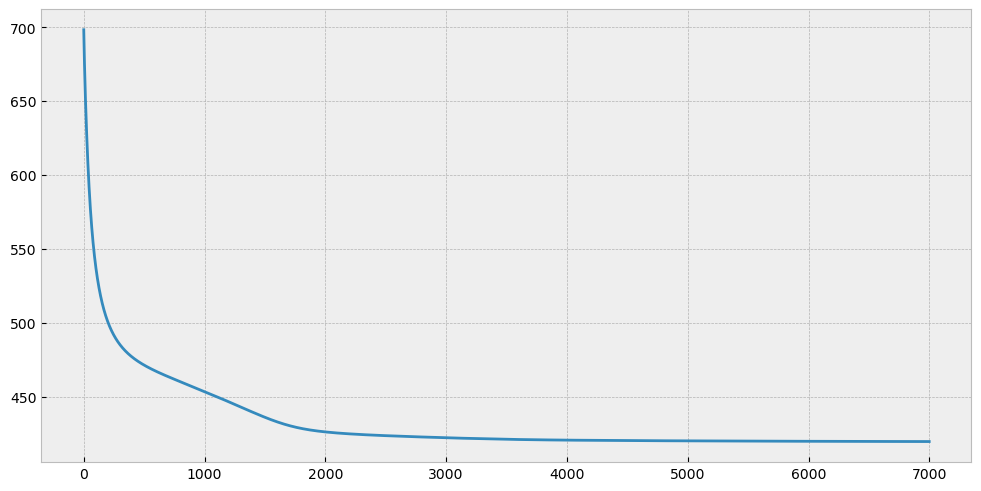

In [65]:
plt.plot(losses)

For the initial parameters of the MCMC, we use first pass the constrained variable through the bijector.

In [66]:
delta_clip = tfb.SoftClip(low=0, high=1).forward(delta)
eta_clip = tfb.SoftClip(low=0, high=(1-delta_clip)).forward(eta)

Test the mcmc log probability function. And it looks good.

In [67]:
sales_log_prob_mcmc(delta_clip, eta_clip, trainable_variables[2], trainable_variables[3], trainable_variables[4], trainable_variables[5])

<tf.Tensor: shape=(), dtype=float32, numpy=-419.7652>

For the MCMC sampling, we don't actually have to specify a bijector for the variables as it is enforced implicitly via the <code>sales_log_prob_mcmc</code> function. But TFP requires us to specify a bijector nonetheless, so the <code>tfb.Identity</code> bijector does the trick by doing absolutly nothing.

In [71]:
@tf.function
def sample_sales_model_posterior(num_chains, num_results, num_burnin_steps):
    
     
    def trace_fn(_, pkr):
        return (
            pkr.inner_results.target_log_prob,
            pkr.inner_results.leapfrogs_taken,
            pkr.inner_results.has_divergence,
            pkr.inner_results.energy,
            pkr.inner_results.log_accept_ratio
    )
    
    hmc = tfp.mcmc.NoUTurnSampler(
        target_log_prob_fn=sales_log_prob_mcmc,
        step_size=0.001
    )
    
    

    initial_state = [
        tf.repeat(delta_clip, num_chains, axis=0, name='init_delta'),
        tf.repeat(eta_clip, num_chains, axis=0, name='init_eta'),
        tf.repeat(b_trend, num_chains, axis=0, name='b_trend'),
        tf.tile(tf.reshape(day_of_week, (1,-1)), multiples=[num_chains, 1], name='init_day_of_week'),
        tf.tile(tf.reshape(b_fourier, (1,1,12)), multiples=[4, 1, 1], name='init_b_fourier'),
        tf.repeat(alpha, 4, axis=0, name='init_alpha')
    ]
    
    #no constraining bijectors is actually needed as the constrain is enforced by th log prob function
    unconstraining_bijectors = [
        tfb.Identity(),
        tfb.Identity(),
        tfb.Identity(),
        tfb.Identity(),
        tfb.Identity(),
        tfb.Identity()
    ]
    
    kernel = tfp.mcmc.TransformedTransitionKernel(
        inner_kernel=hmc, bijector=unconstraining_bijectors
    )
    
    samples, kernel_results = tfp.mcmc.sample_chain(
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        current_state=initial_state,
        kernel=kernel,
        trace_fn=trace_fn
    )
    
    

   
    return samples, kernel_results

We run the MCMC sampler to obtain 4000 samples which takes around 3 hours. You could use the Hamiltonian Monte Carlo algorithm for a faster result, but it produces divergent samples that does not converge to any particular distribution.

In [72]:
samples, sampler_stat = sample_sales_model_posterior(
    num_chains=4, num_results=4000, num_burnin_steps=1000)

In [74]:
sample_stats_name = ['lp', 'tree_size', 'diverging', 'energy', 'mean_tree_accept']

sample_stats = {k:v.numpy().T for k, v in zip(sample_stats_name, sampler_stat)}

sample_stats['tree_size'] = np.diff(sample_stats['tree_size'], axis=1)


In [73]:
var_name = ['delta', 'eta', 'b_trend', 'day_of_week', 'b_fourier', 'alpha']
posterior = {k:np.swapaxes(tf.squeeze(v).numpy(), 1, 0) 
             for k, v in zip(var_name, samples)}

In [70]:
# posterior['delta'] = tfb.SoftClip(low=0,high=1).forward(posterior['delta']).numpy()

In [71]:
# posterior['eta'] = tfb.SoftClip(low=0, high=(1-posterior['delta'])).forward(posterior['eta'])

Looking at the traceplots and the forest plots, we are satisfied with the result of the samples from the posterior. The R-Hat values also produces values close to zero for all parameters, which indicates that the sampling is successful.

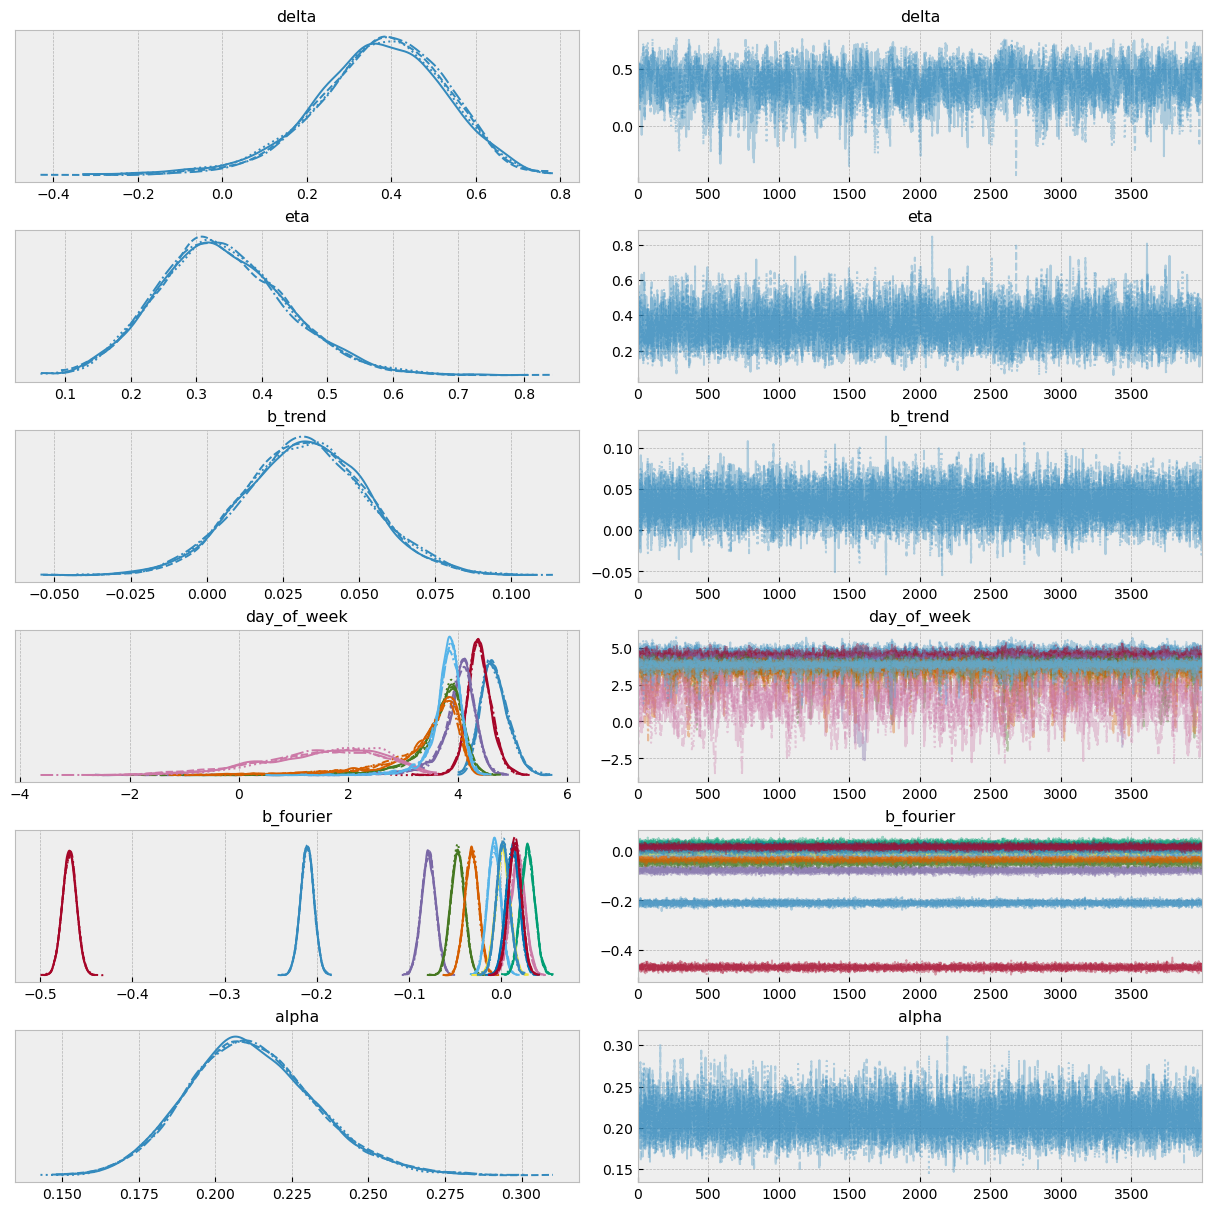

In [75]:
az_trace = az.from_dict(posterior=posterior)
az.plot_trace(az_trace);

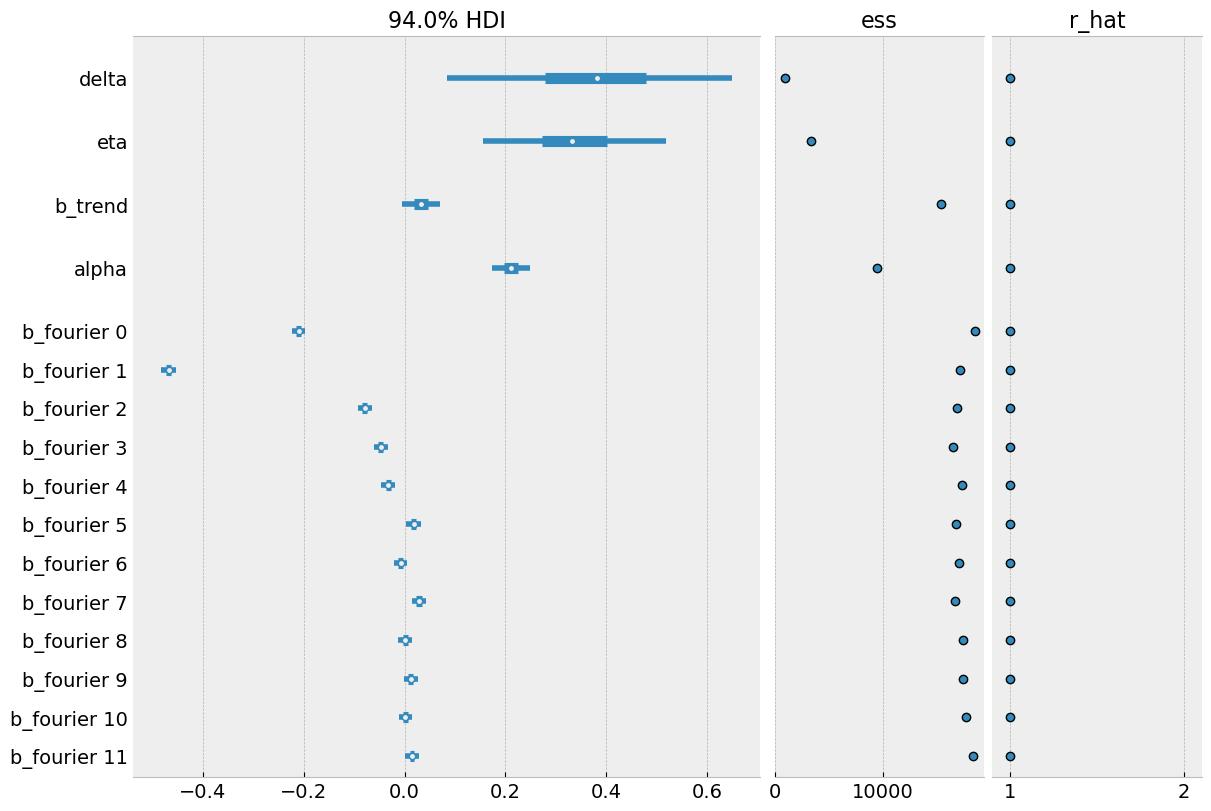

In [76]:
az.plot_forest(az_trace,
               kind="forestplot",
               var_names=['delta', 'eta', 'b_trend', 'alpha', 'b_fourier'],
               linewidth=4,
               r_hat=True,
               ess=True,
               combined=True,
               ridgeplot_overlap=1.5,
               figsize=(12, 8));

In [77]:
az.summary(data=posterior)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
delta,0.372,0.154,0.084,0.650,0.005,0.004,915.0,915.0,914.0,2006.0,1.00
eta,0.339,0.097,0.156,0.519,0.002,0.001,3395.0,3395.0,3440.0,7385.0,1.00
b_trend,0.032,0.020,-0.005,0.071,0.000,0.000,15397.0,12034.0,15398.0,9434.0,1.00
day_of_week[0],4.680,0.249,4.234,5.163,0.008,0.006,896.0,891.0,919.0,1874.0,1.00
day_of_week[1],4.395,0.225,3.980,4.820,0.005,0.003,2457.0,2283.0,2449.0,2092.0,1.00
day_of_week[2],3.964,0.552,3.267,4.617,0.031,0.022,308.0,308.0,1701.0,656.0,1.00
day_of_week[3],3.605,0.632,2.454,4.404,0.024,0.017,674.0,674.0,1303.0,793.0,1.00
day_of_week[4],3.356,0.806,1.764,4.299,0.033,0.023,599.0,599.0,909.0,723.0,1.00
day_of_week[5],1.481,1.105,-0.538,3.321,0.041,0.029,714.0,714.0,714.0,1211.0,1.01
day_of_week[6],3.783,0.322,3.242,4.311,0.006,0.005,2522.0,2522.0,4855.0,2264.0,1.00


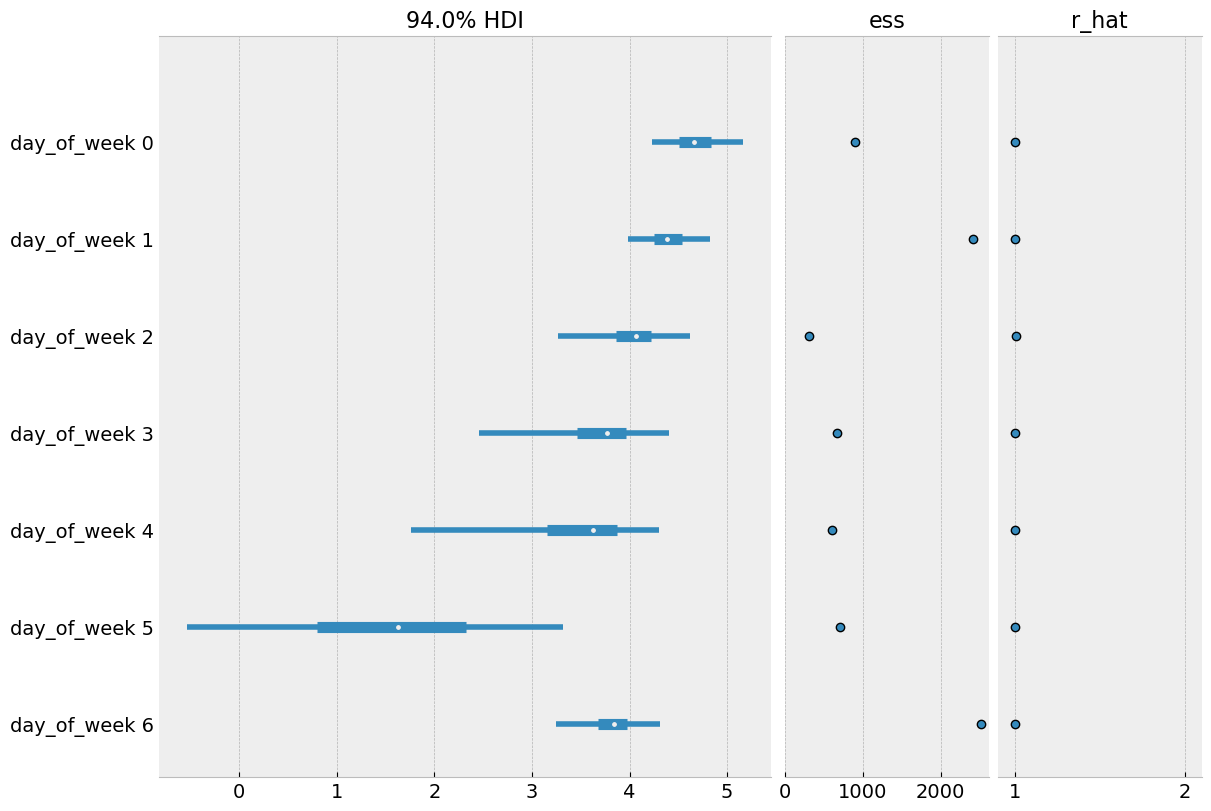

In [78]:
az.plot_forest(az_trace,
               kind="forestplot",
               var_names=['day_of_week'],
               linewidth=4,
               r_hat=True,
               ess=True,
               combined=True,
               ridgeplot_overlap=1.5,
               figsize=(12, 8));

### Posterior Predictive Distribution

Before we make sales forecast on out-of-sample data, let's first verify our model by visualizing the posterior predictive distribution.

Collect all parameter samples produced by the MCMC algorithm.

In [79]:
delta_samples = samples[0][:, 0]

In [80]:
eta_samples = samples[1][:,0]

In [81]:
b_trend_samples = samples[2][:,0]

In [82]:
day_of_week_samples = samples[3][:,0]

In [83]:
b_fourier_samples = samples[4][:,0]

In [84]:
alpha_samples = samples[5][:, 0]

Calculate the Fourier features, day of week contribution $b_{dow}$ and trend contribution $b_{trend}$

In [85]:
fourier_contribution_samples = tf.squeeze(tf.linalg.matmul(b_fourier_samples, fourier_features_train.T))

In [86]:
day_of_week_contribution_samples = tf.gather(day_of_week_samples, dayofweek_idx_train, axis=1)

In [87]:
trend_contribution_samples = tf.reshape(b_trend_samples, shape=(-1, 1)) * trend_train

Calculate the seasonality effect linear model.

In [88]:
# fourier_contribution + dayofweek_contibution + trend_contribution
seasonality_samples = fourier_contribution_samples + day_of_week_contribution_samples + trend_contribution_samples

In [89]:
seasonality_samples = tf.math.exp(seasonality_samples)

In [90]:
dispersion_samples = tf.square(alpha_samples)

In [91]:
mu = np.ones([4000, len(sales_train)], dtype=np.float32)

In [92]:
mu[:, 0] = sales_train[0]

Calculate the damped mean linear model by combining effects of the seasonality and previous observation.

In [93]:
for i in range(1, len(mu[0])):
    mu[:,i] = (1 - delta_samples - eta_samples) * seasonality_samples[:, i] + delta_samples * mu[:,i-1]  + eta_samples * sales_train[i-1]

In [94]:
alpha_samples =  tf.square(alpha_samples)

Construct the posterior predictive distribution from the parameter samples calculated earlier.

In [95]:
sales_posterior = tfd.NegativeBinomial.experimental_from_mean_dispersion(mean=mu, dispersion=tf.reshape(alpha_samples, shape=(-1,1)))

In [96]:
sales_posterior = tfd.Independent(sales_posterior, reinterpreted_batch_ndims=1)

Sample from the posterior predictive distribution.

In [97]:
sales_samples = sales_posterior.sample().numpy()

Good. So far, we succesfully replicate the result of the sales model from the [original blog post](https://juanitorduz.github.io/short_time_series_pymc/). Next, we will 

C:\Users\User\Anaconda3\envs\bayesian\lib\site-packages\arviz\stats\stats.py:493: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
C:\Users\User\Anaconda3\envs\bayesian\lib\site-packages\arviz\stats\stats.py:493: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


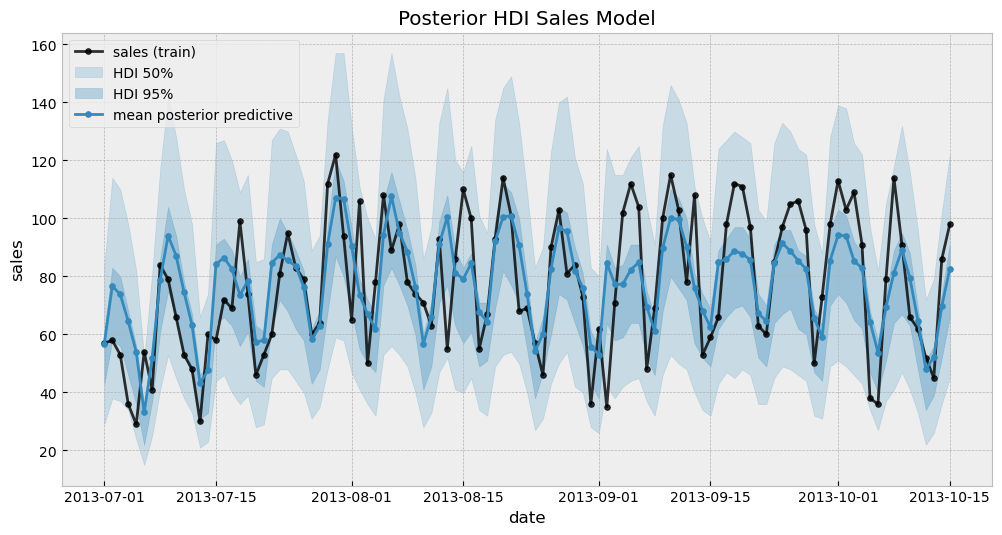

In [98]:
fig, ax = plt.subplots()

sns.lineplot(
    x="date",
    y="sales",
    data=df_train,
    marker="o",
    color="black",
    alpha=0.8,
    markersize=4,
    markeredgecolor="black",
    label="sales (train)",
)
az.plot_hdi(
    x=date_train,
    y=sales_samples,
    hdi_prob=0.95,
    color="C0",
    smooth=False,
    fill_kwargs={"label": "HDI 50%", "alpha": 0.2},
    ax=ax,
)
az.plot_hdi(
    x=date_train,
    y=sales_samples,
    hdi_prob=0.5,
    color="C0",
    smooth=False,
    fill_kwargs={"label": "HDI 95%", "alpha": 0.3},
    ax=ax,
)
sns.lineplot(
    x=date_train,
    y=np.mean(sales_samples, axis=0),
    marker="o",
    color="C0",
    markersize=4,
    markeredgecolor="C0",
    label="mean posterior predictive",
    ax=ax,
)
ax.legend(loc="upper left")
ax.set(title="Posterior HDI Sales Model");

# Out of Sample Predictions

In [99]:
fourier_contribution_posterior = tf.squeeze(tf.linalg.matmul(b_fourier_samples, fourier_features.T))

In [100]:
day_of_week_contribution_posterior = tf.gather(day_of_week_samples, dayofweek_idx, axis=1)

In [101]:
trend_contribution_posterior = tf.reshape(b_trend_samples, shape=(-1, 1)) * trend.values

In [102]:
seasonality_posterior = fourier_contribution_posterior + day_of_week_contribution_posterior + trend_contribution_posterior

In [103]:
seasonality_posterior = tf.math.exp(seasonality_posterior)

In [104]:
sales_posterior = np.zeros(shape=(4000, n))

In [105]:
sales_posterior[:, :n_train] = sales_samples

In [106]:
mu_posterior = np.zeros(shape=(4000, n), dtype=np.float32)
mu_posterior[:, :n_train] = mu

The sales forecast can be made by calculating the damped mean and use it to parameterize the Negative Binomial distribution at each time step. Then, the sales forecast is made by sampling the Negative Binomial distribution.

In [107]:
for i in range(n_train, n):
    mu_posterior[:,i] = (1 - delta_samples - eta_samples) * seasonality_posterior[:, i] + delta_samples * mu_posterior[:,i-1]  + eta_samples * sales_posterior[:,i-1]
    current_sales_dist = tfd.NegativeBinomial.experimental_from_mean_dispersion(mean=mu_posterior[:,i], dispersion=alpha_samples)
    sales_posterior[:,i] = current_sales_dist.sample().numpy()

In [108]:
sales_posterior_hdi95 = az.hdi(sales_posterior, hdi_prob=0.95)
sales_posterior_hdi50 = az.hdi(sales_posterior, hdi_prob=0.50)

C:\Users\User\Anaconda3\envs\bayesian\lib\site-packages\arviz\stats\stats.py:493: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


Fantastic. The result looks similar to the [original post](https://juanitorduz.github.io/short_time_series_pymc/) using PyMC3.

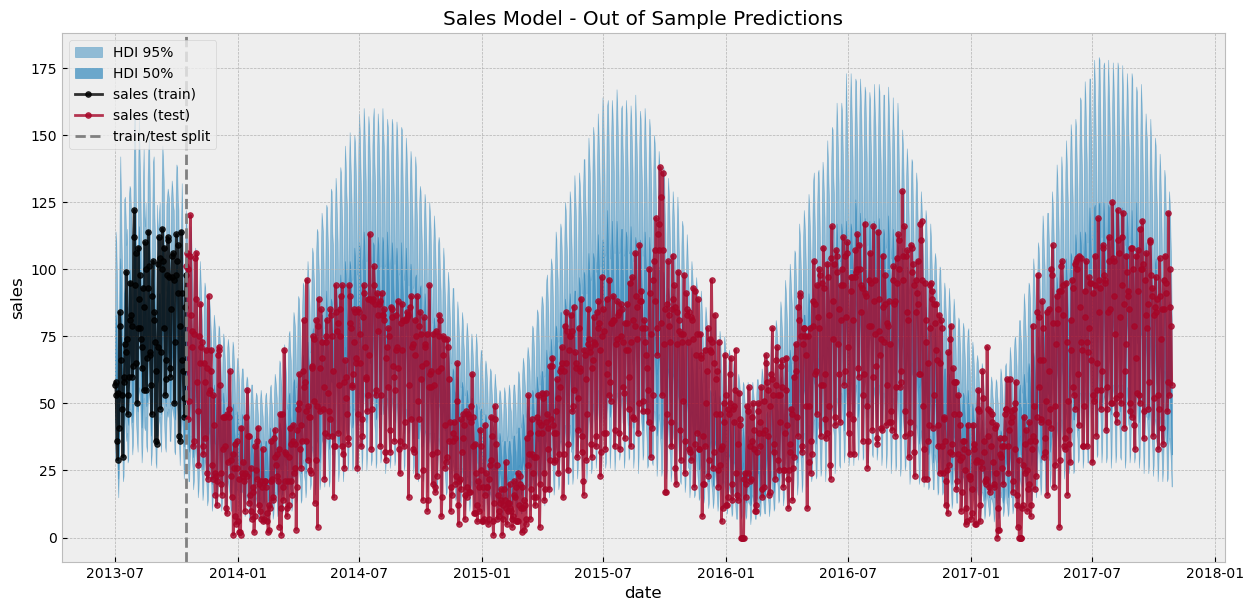

In [109]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.fill_between(
    x=date[-n:],
    y1=sales_posterior_hdi95[:, 0],
    y2=sales_posterior_hdi95[:, 1],
    color="C0",
    label="HDI 95%",
    alpha=0.5,
)

ax.fill_between(
    x=date[-n:],
    y1=sales_posterior_hdi50[:, 0],
    y2=sales_posterior_hdi50[:, 1],
    color="C0",
    label="HDI 50%",
    alpha=0.7,
)

sns.lineplot(
    x="date",
    y="sales",
    data=df_train,
    marker="o",
    color="black",
    alpha=0.8,
    markersize=4,
    markeredgecolor="black",
    label="sales (train)",
    ax=ax,
)

sns.lineplot(
    x="date",
    y="sales",
    data=df_test,
    marker="o",
    color="C1",
    alpha=0.8,
    markersize=4,
    markeredgecolor="C1",
    label="sales (test)",
    ax=ax,
)

ax.axvline(x=train_test_date, color="gray", linestyle="--", label="train/test split")
ax.legend(loc="upper left")
ax.set(title="Sales Model - Out of Sample Predictions");